In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("loans.csv", header = 6)

In [4]:
#Create an extra column, GENDER_GROUPS, that separates into females/males/multiple
df['GENDER_GROUPS'] = df['BORROWER_GENDERS']
df['GENDER_GROUPS'][(df['GENDER_GROUPS']=='male') | (df['GENDER_GROUPS']=='female')]
df['GENDER_GROUPS'] = df['GENDER_GROUPS'].where((df['GENDER_GROUPS']=='male') | (df['GENDER_GROUPS']=='female'),'group')

In [5]:
expired = df[df['STATUS']=='expired']
funded = df[df['STATUS']=='funded']
df.groupby('STATUS').count()

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,...,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,GENDER_GROUPS
STATUS,,,,,,,,,,,,,,,,,,,,,
expired,76561,76162,76552,76545,70764,76561,76561,76552,88,76561,...,76561,76561,76561,64920,76162,76552,76552,76561,76561,76561
fundRaising,6436,6436,6436,6436,6436,6436,6436,6436,5,6436,...,6436,6436,6436,4753,6436,6436,6436,6436,6436,6436
funded,1592264,1551637,1555593,1555565,1151955,1592264,1592264,1555593,754,1592264,...,1592264,1592264,1592264,779958,1551637,1555593,1555593,1592264,1592264,1592264
refunded,7529,0,0,0,0,7529,7529,0,0,7529,...,7529,7529,7529,1988,0,0,0,7529,7529,7529


In [6]:
expired.count()

LOAN_ID                            76561
LOAN_NAME                          76162
ORIGINAL_LANGUAGE                  76552
DESCRIPTION                        76545
DESCRIPTION_TRANSLATED             70764
FUNDED_AMOUNT                      76561
LOAN_AMOUNT                        76561
STATUS                             76561
IMAGE_ID                           76552
VIDEO_ID                              88
ACTIVITY_NAME                      76561
SECTOR_NAME                        76561
LOAN_USE                           76546
COUNTRY_CODE                       76561
COUNTRY_NAME                       76561
TOWN_NAME                          68616
CURRENCY_POLICY                    76561
CURRENCY_EXCHANGE_COVERAGE_RATE    66212
CURRENCY                           76561
PARTNER_ID                         73919
POSTED_TIME                        76561
PLANNED_EXPIRATION_TIME            76369
DISBURSE_TIME                      73919
RAISED_TIME                            2
LENDER_TERM     

In [7]:
funded_rate = funded['LOAN_ID'].count()/(funded['LOAN_ID'].count()+expired['LOAN_ID'].count())
sector_pivot = df.pivot_table(values = 'LOAN_ID', index = 'SECTOR_NAME', columns = 'STATUS', aggfunc = 'count')
sector_pivot['funded_expired_total'] = sector_pivot['expired']+ sector_pivot['funded']
sector_pivot['expected'] = (sector_pivot['funded_expired_total']*funded_rate).astype(int)
sector_pivot

STATUS,expired,fundRaising,funded,refunded,funded_expired_total,expected
SECTOR_NAME,,,,,,
Agriculture,20131,2115,394868,1885,414999,395960
Arts,238,14,34194,141,34432,32852
Clothing,5051,309,88326,517,93377,89093
Construction,620,87,20689,158,21309,20331
Education,935,74,56171,188,57106,54486
Entertainment,151,4,2197,11,2348,2240
Food,13156,1452,360356,1636,373512,356376
Health,1354,113,20990,95,22344,21318
Housing,6283,228,67683,330,73966,70572


In [8]:
sector_expired = sector_pivot['expired'].reset_index()
sector_funded = sector_pivot['funded'].reset_index()
sector_expected = sector_pivot['expected'].reset_index()

In [9]:
def plot_with_fill(x, y, label):
    lines = plt.plot(x, y, label=label, lw=2)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_c())
    plt.legend(loc='best')

In [11]:
def get_funded_df(df,column_to_explore):
    '''
    Takes the Kiva loan df and creates a new df that pivots on the desired column to explore and takes the count between 
    expired and funded loans. Then creates,removes,renames columns so that the df only contains the category values as 
    rows names and funded/unfunded/total as columns headers. 
    '''
    pivot = df.pivot_table(values = 'LOAN_ID', index = column_to_explore, columns = 'STATUS', aggfunc = 'count')
    pivot['FUNDED'] = pivot['funded']
    pivot['UNFUNDED'] = pivot['expired']
    pivot['TOTAL'] = pivot['expired']+ pivot['funded']
    pivot = pivot.drop(['fundRaising','refunded','expired','funded'],axis=1)
    
    return pivot

In [12]:
def beta_distributions(df,x):
    
    '''
    Takes the funded DataFrame and returns a dict that contains the total amount of funded and unfunded loans based on each variable
    '''

    beta_functions = {}

    for row in df.reset_index().iloc[:,0]:
        alpha = df.loc[row,'FUNDED']
        beta = df.loc[row,'UNFUNDED']
        beta_functions[row] = stats.beta(alpha,beta).pdf(x)
        
    return beta_functions

In [13]:
def graph_beta(function_dict,x):

    for label,function in function_dict.items(): 
        plot_with_fill(x,function,label)
        ax.annotate(label,rotation=0,xy=((function.argmax()/10000),function.max()),
                    xytext=((function.argmax()/10000)+0.003,(function.max())+50),
                    arrowprops=dict(arrowstyle="simple",fc="0.5", ec="none",connectionstyle="arc3,rad=0.3"))
        ax.annotate('Average Funded Rate',xy=(0.954122810959807,1600),xytext=(0.955,1450))
        ax.axvline(0.954122810959807, color='b', linestyle=':')
        
    return ax

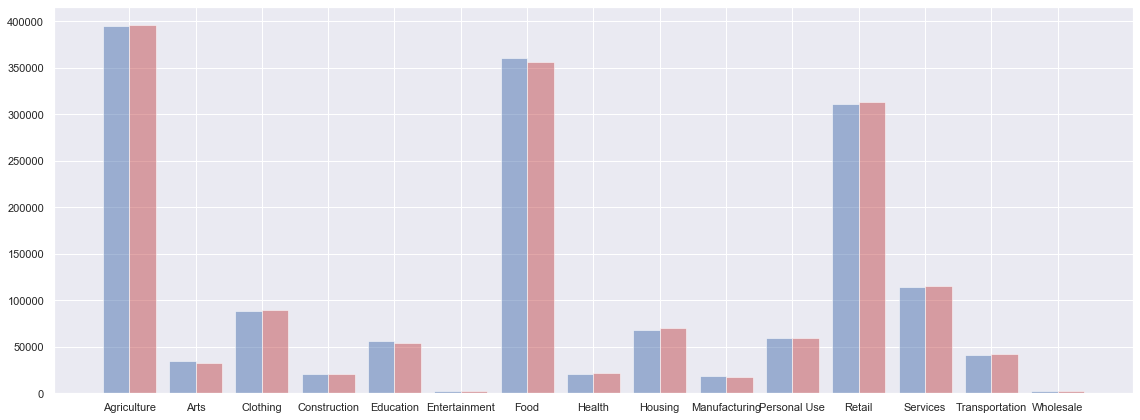

In [605]:
fig,ax = plt.subplots(figsize=(16,6))

#ax.bar(sector_expired.iloc[:,0], sector_expired.iloc[:,1],color='g',width = 0.4,align ='center',alpha=.5,)
ax.bar(sector_funded.iloc[:,0], sector_funded.iloc[:,1],color='b',width = -0.4,align ='edge',alpha=0.5)
ax.bar(sector_expected.iloc[:,0], sector_expected.iloc[:,1],color='r',width = 0.4,align ='edge',alpha=0.5)

#ax.axis(ymax=22000)

fig.tight_layout()

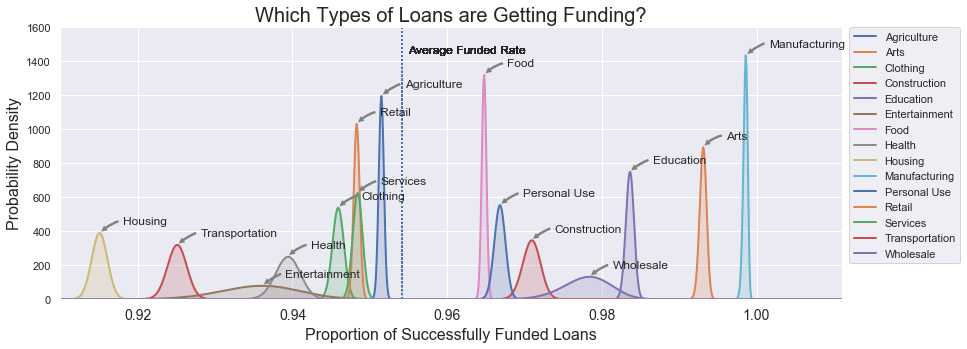

In [19]:
fig,ax = plt.subplots(figsize=(14,5))
x = np.arange(0,1.1,.0001)

sector_df = get_funded_df(df,'SECTOR_NAME')
sector_beta = beta_distributions(sector_df,x)
graph_beta(sector_beta,x)

plt.xlim(0.91,1.011)
plt.ylim(0,1600)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel('Proportion of Successfully Funded Loans',fontsize=16)
plt.title('Which Types of Loans are Getting Funding?',fontsize=20)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

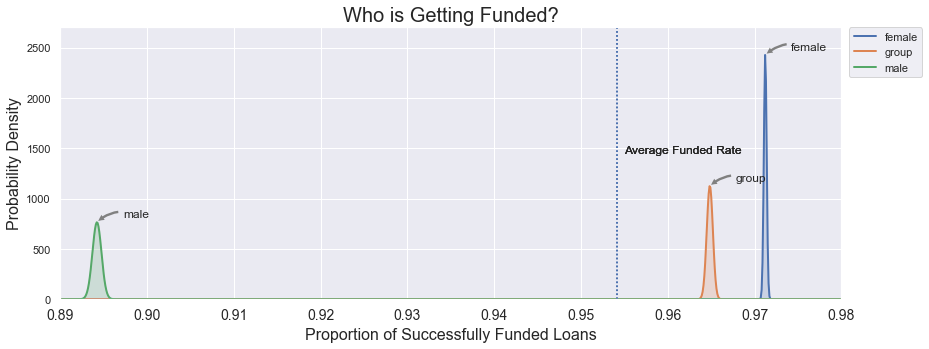

In [20]:
fig,ax = plt.subplots(figsize=(14,5))
x = np.arange(0,1.1,.0001)

gender_df = get_funded_df(df,'GENDER_GROUPS')
gender_beta = beta_distributions(gender_df,x)
graph_beta(gender_beta,x)

plt.xlim(0.89,0.98)
plt.ylim(0,2700)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel('Proportion of Successfully Funded Loans',fontsize=16)
plt.title('Who is Getting Funded?',fontsize=20)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [21]:
country_df = get_funded_df(df,'COUNTRY_NAME')
country_df = country_df.fillna(0)
country_df['TOTAL'] = country_df['FUNDED'] + country_df['UNFUNDED']
country_df = country_df.sort_values('TOTAL',ascending=False).head(10)
country_df

STATUS,FUNDED,UNFUNDED,TOTAL
COUNTRY_NAME,,,
Philippines,332765.0,3191.0,335956.0
Kenya,165964.0,9366.0,175330.0
Peru,91471.0,1476.0,92947.0
Cambodia,86738.0,1949.0,88687.0
El Salvador,63810.0,8946.0,72756.0
Uganda,53364.0,4302.0,57666.0
Pakistan,52700.0,2123.0,54823.0
Tajikistan,48751.0,4102.0,52853.0
Colombia,39157.0,7166.0,46323.0


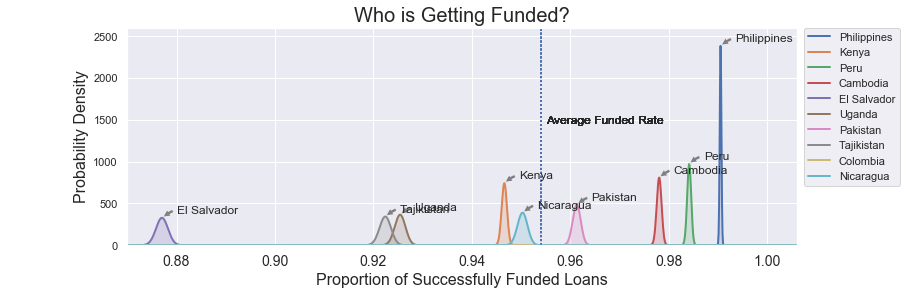

In [22]:
fig,ax = plt.subplots(figsize=(12,4))
x = np.arange(0,1.1,.0001)

country_beta = beta_distributions(country_df,x)
graph_beta(country_beta,x)

plt.xlim(0.87,1.006)
plt.ylim(0,2600)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel('Proportion of Successfully Funded Loans',fontsize=16)
plt.title('Who is Getting Funded?',fontsize=20)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [728]:
female_beta = stats.beta(gender_status_df['funded']['female'], gender_status_df['expired']['female']).pdf(x)
male_beta = stats.beta(gender_status_df['funded']['male'], gender_status_df['expired']['male']).pdf(x)
female_beta_rvs = stats.beta(female_funded, female_total-female_funded).rvs(10000)
male_beta_rvs = stats.beta(male_funded, male_total-male_funded).rvs(10000)

In [413]:
prob1 = (female_beta_rvs > male_beta_rvs + .075).mean() * 100
prob2 = (female_beta_rvs > male_beta_rvs + .0775).mean() * 100
prob3 = (female_beta_rvs > male_beta_rvs + .080).mean() * 100
print('There is a {:.2f}% probability that a single female asking for a loan has a 7.5% better chance than a single male to have the loan successfully funded\n'.format(prob1))
print('There is a {:.2f}% probability that a single female asking for a loan has a 7.75% better chance than a single male to have the loan succesfully funded\n'.format(prob2))
print('There is a {:.2f}% probability that a single female asking for a loan has a 8.0% better chance than a single male to have the loan successfully funded\n'.format(prob3))

There is a 99.99% probability that a single female asking for a loan has a 7.5% better chance than a single male to have the loan successfully funded

There is a 18.08% probability that a single female asking for a loan has a 7.75% better chance than a single male to have the loan succesfully funded

There is a 0.00% probability that a single female asking for a loan has a 8.0% better chance than a single male to have the loan successfully funded



In [236]:
def get_rvs(result):
    ''' The function will return the pdf for a given beta distribution

    Parameters
    -----------
    x : Array of x values
    site : Array cooresponding to the site in question

    Returns
    --------
    numpy array
    '''
    alpha = result[result['GENDER_GROUPS'] == 'female']['LOAN_ID'].count()
    beta = result[(result['GENDER_GROUPS'] == 'female') | (result['GENDER_GROUPS'] == 'male')]['LOAN_ID'].count() - alpha
    
    return stats.beta(a=alpha, b=beta).rvs(10000)

In [201]:
country_top = df.groupby('COUNTRY_NAME')['LOAN_ID'].count().sort_values(ascending=False).head(25)

Text(0.5, 0, 'Number of Loans')

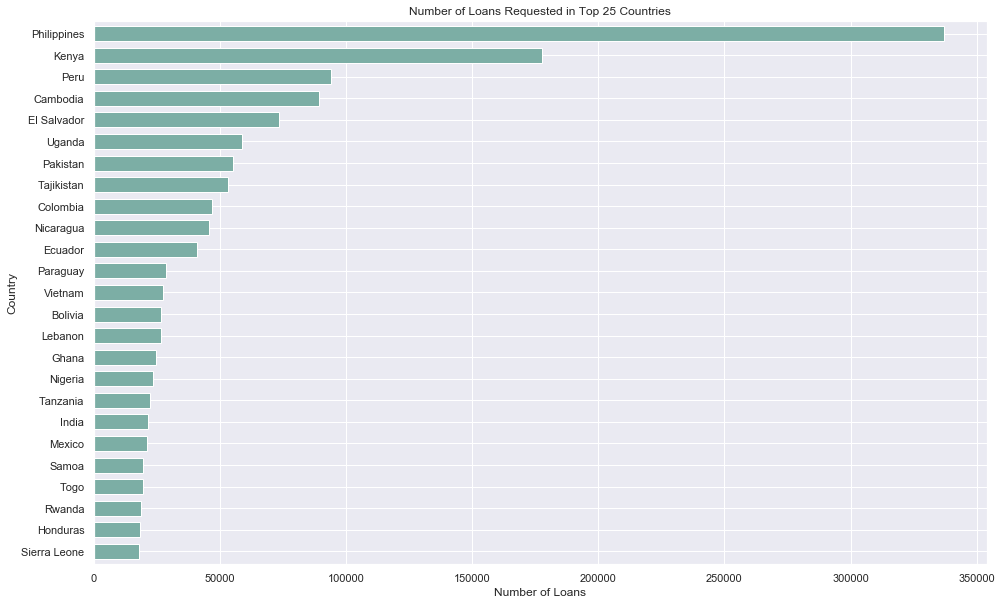

In [360]:
ax = country_top.plot(kind='barh', figsize=(16,10), color='#7caea5', zorder=2, width=0.7)

ax.invert_yaxis()
plt.title('Number of Loans Requested in Top 25 Countries')
plt.ylabel('Country')
plt.xlabel('Number of Loans')